# RNN_torch_code

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt
import collections
import re
import numpy as np

## Net


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [4]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [5]:
class RNNModel(nn.Module):
  '''循环神经网络'''
  def __init__(self, rnn_layer, vocab_size, **kwargs):
    super().__init__(**kwargs)
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    # 如果RNN是双向的(之后将介绍)，num_directions应该是2，否则应该是1
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size) 
    else:
      self.num_directions = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
  
  def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数) 
    # 它的输出形状是(时间步数*批量大小,词表大小)。
    output = self.linear(Y.reshape((-1, Y.shape[-1]))) 
    return output, state

  def begin_state(self, device, batch_size=1): 
    if not isinstance(self.rnn, nn.LSTM):
      # nn.GRU以张量作为隐状态
      return torch.zeros((self.num_directions * self.rnn.num_layers,
                             batch_size, self.num_hiddens),
                            device=device)
    else:
    # nn.LSTM以元组作为隐状态 
      return (torch.zeros((self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                    batch_size, self.num_hiddens), device=device))


In [6]:
net = RNNModel(rnn_layer, vocab_size=len(vocab))

## Train

In [7]:
def predict(prefix, num_preds, net, vocab, device=torch.device('cuda')):
  def get_word_order_tensor(sign, device):
    return torch.LongTensor([sign]).reshape(1,1).to(device)

  state = net.begin_state(batch_size=1, device=device)
  output = []

  net.to(device)
  for y in prefix[:-1]:
    word_num = get_word_order_tensor(vocab[y], device)
    _, state = net(word_num, state)
    output.append(int(word_num))
  word_num = get_word_order_tensor(vocab[prefix[-1]], device)
  output.append(word_num)

  for _ in range(num_preds):
    word_num = get_word_order_tensor(output[-1], device)
    y, state = net(word_num, state)
    output.append(int(torch.argmax(y, axis=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in output])

def train_rnn(net, epochs, train_iter, loss, optim, 
              state=None, grad_clip_theta=1, device=torch.device('cuda')):
  # 梯度裁剪
  def grad_clipping(net, theta=grad_clip_theta):
    if isinstance(net, nn.Module):
      params = [p for p in net.parameters() if p.requires_grad]
    else:
      params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
      for param in params:
        param.grad[:] *= theta / norm

  loss = loss
  opt = optim
  state = state
  epochs = epochs
  perplexity = []

  net.to(device=device)
  for epoch in range(epochs):
    epoch_loss = []
    for X, Y in train_iter:
      y = Y.T.reshape(-1)
      X, y = X.to(device), y.to(device)
      state = net.begin_state(batch_size=X.shape[0], device=device)
      y_hat, state = net(X, state)
      # state 是叶子节点，不可以直接设置grad
      state = (state[0].detach(),)
      l = loss(y_hat, y.long()).mean()
      epoch_loss.append(l.item())
      
      opt.zero_grad()
      l.backward()
      grad_clipping(net)
      opt.step()
    epoch_perplexity = np.exp(np.mean(epoch_loss))
    if (epoch+1)%50==0:
      print(f'epoch: {epoch+1}, perplexity:{epoch_perplexity:f}')
    perplexity.append(epoch_perplexity)

  plt.plot(perplexity, label='train', color='b', linestyle='solid')
  plt.xlabel('epoch')
  plt.ylabel('perplexity')
  plt.legend()
  plt.show()

epoch: 50, perplexity:7.538324
epoch: 100, perplexity:4.767982
epoch: 150, perplexity:2.839490
epoch: 200, perplexity:2.278068
epoch: 250, perplexity:2.060673
epoch: 300, perplexity:1.811331
epoch: 350, perplexity:1.703063
epoch: 400, perplexity:1.733841
epoch: 450, perplexity:1.497020
epoch: 500, perplexity:1.708808


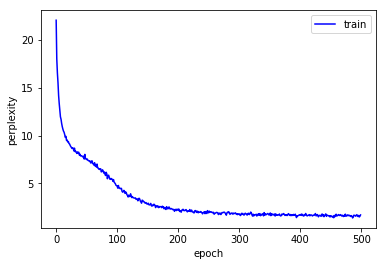

CPU times: user 16.4 s, sys: 1.96 s, total: 18.3 s
Wall time: 20.6 s


In [8]:
%%time
loss = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=1)
train_rnn(net, epochs=500, train_iter=train_iter, loss=loss, optim=opt)

In [9]:
print(predict('time traveller ', 20, net, vocab))

time traveller but now you begin to
